In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import sys

# change this to your corresponding folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'stat-453'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['data', '__pycache__', 'models', 'model.py', 'noise_testing', 'videos', 'diffusion.py', 'experiment.json', 'stat_453_test', 'STAT 453.gslides', 'stat_453']


In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


# Prepare dataset

In [ ]:
DATASET_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'data/images')

DATASET_PATH

'drive/MyDrive/stat-453/data/images'

In [ ]:
image_size = 64
batch_size = 28

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
                               transforms.Resize((image_size, image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

print("Total number of classes in the dataset: ", len(dataset))
print("Number of different samples in the dataset: ", len(dataset.classes))

train_dataloader = data_utils.DataLoader(dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers = 12,
                                        )

100%|██████████| 170498071/170498071 [00:13<00:00, 13027896.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Total number of classes in the dataset:  50000
Number of different samples in the dataset:  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


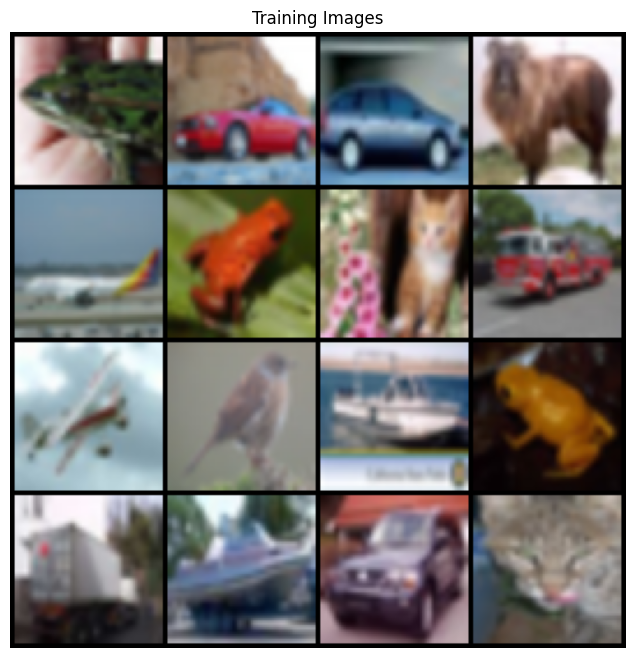

In [ ]:
# uncomment to plot the samples in the dataset

import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

real_batch, _ = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:16],
                                         nrow = 4,
                                         padding=2,
                                         normalize=True),(1,2,0)))

In [ ]:
# uncomment to test beta in diffusion

# from diffusion import Improved_CFG_Diffusion
# import matplotlib.pyplot as plt
# dtype = dataset.__getitem__(0)[0].dtype
# diffusion = Improved_CFG_Diffusion(2000, (image_size, image_size), dtype = dtype, device = DEVICE)
# plt.plot(diffusion.beta.cpu())
# plt.show()

NameError: name 'dataset' is not defined

# Train

In [ ]:
from diffusion import Improved_CFG_Diffusion
from model import UNet
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# random generator
rng = np.random.default_rng()

# set up hyper parameter
lr = 3e-4 #0.01
epochs = 0 #300
beta = 0.995
dtype = dataset.__getitem__(0)[0].dtype
num_classes = len(dataset.classes)

cifar10_dict = dataset.class_to_idx

os.makedirs("models", exist_ok = True)
model = UNet(num_classes = num_classes, device = DEVICE)
# uncomment when necessary load the previous trained steps
# model.load_state_dict(torch.load(os.path.join("models", f"cifar_ckpt.pt")))
model = model.to(DEVICE)
diffusion = Improved_CFG_Diffusion(1024, (image_size, image_size), dtype = dtype, device = DEVICE)
# change optimization after run ADAM, or change loss func?
optimizer = optim.Adam(model.parameters(), lr = lr)
ema_model = optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(beta))
# uncomment when necessary load the previous trained steps  (122 + 15 + 96 + 26 + 41)
# ema_model.load_state_dict(torch.load(os.path.join("models", f"cifar_ema_ckpt.pt")))
ema_model = ema_model.to(DEVICE)
loss_plot = []


for e in range(epochs):
  torch.save(ema_model.state_dict(), os.path.join("models", f"cifar_ema_ckpt.pt"))
  torch.save(model.state_dict(), os.path.join("models", f"cifar_ckpt.pt"))
  if e % 10 == 0 and e != 0:
    name = "dog"
    noise = torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE)
    label = torch.tensor([cifar10_dict[name]], dtype = torch.long, device = DEVICE)
    image = diffusion.inference(ema_model, noise, label = label)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
    plt.show()

  avg_loss = []

  for i, (inputs, targets) in enumerate(train_dataloader):

    model.train()
    inputs = inputs.to(dtype = dtype, device = DEVICE)
    targets = targets.to(dtype = torch.long, device = DEVICE)

    p_unconditional = rng.random()

    if p_unconditional < 0.1:
      targets = None

    loss = diffusion(model, inputs, targets)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
    ema_model.update_parameters(model)

    model.eval()
    avg_loss.append(loss)

    if i % 500 == 0:
      print("Training epoch [{}/{}], iteration [{}/{}] || The loss is {:.5f}".format(e, epochs, i, len(train_dataloader), loss))

  model.eval()
  print("Training epoch [{}/{}] || The loss is {:.5f}".format(e, epochs, sum(avg_loss) / len(avg_loss)))

  loss_plot.append(sum(avg_loss) / len(avg_loss))
  if (e % 10 == 0 and e != 0) or (e == epochs - 1):
    loss_plot_cpu = [e.cpu().detach().numpy() for e in loss_plot]
    plt.plot(loss_plot_cpu)
    plt.savefig(f'training_loss_plot.png')
    plt.show()

In [ ]:
# uncomment if training
# optim.swa_utils.update_bn(train_dataloader, ema_model)

# After training

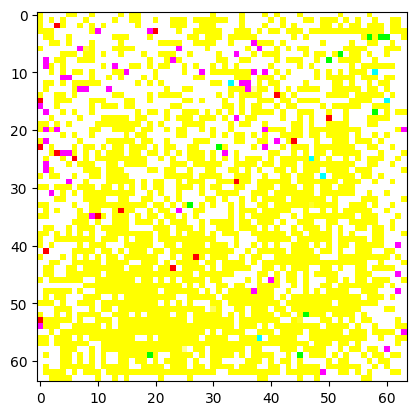

In [ ]:
name = "horse"
diffusion = Improved_CFG_Diffusion(1000, (image_size, image_size), dtype = dtype, device = DEVICE)
noise = torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE)
label = torch.tensor([cifar10_dict[name]], dtype = torch.long, device = DEVICE)
image = diffusion.inference(model, noise, label = label)
plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
plt.show()

# To generate on the trained parameters

EMA Mode

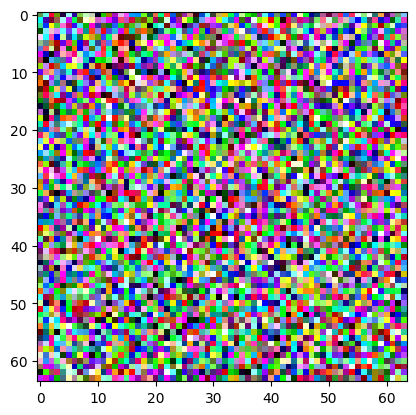

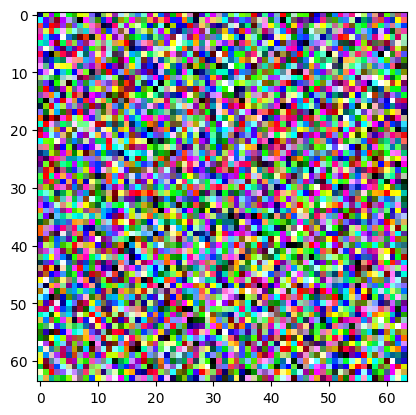

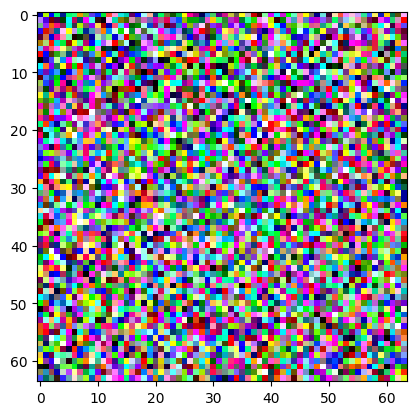

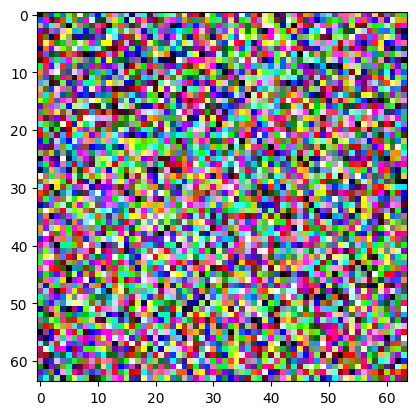

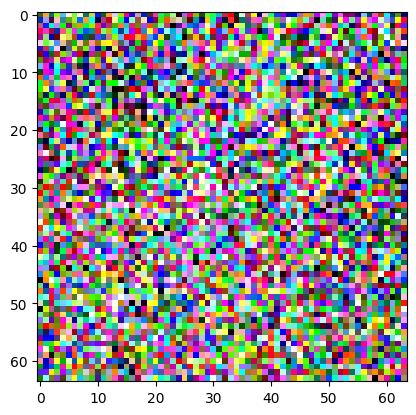

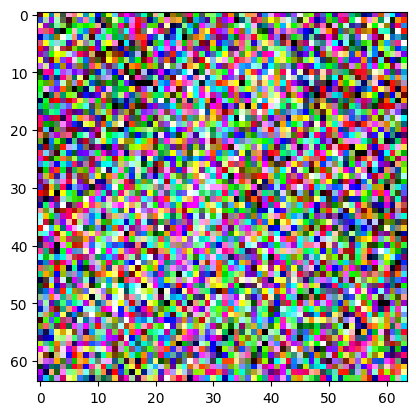

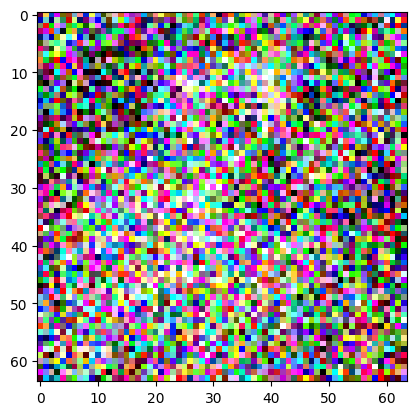

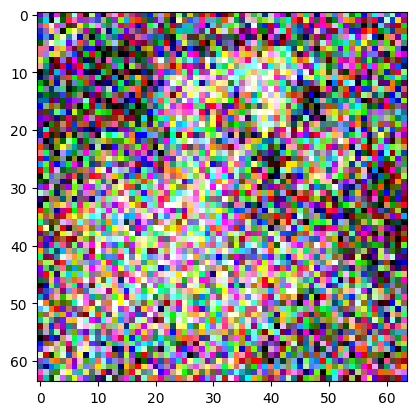

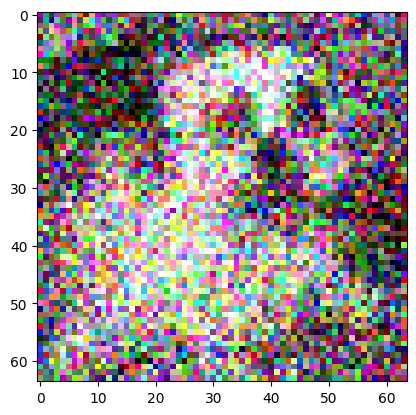

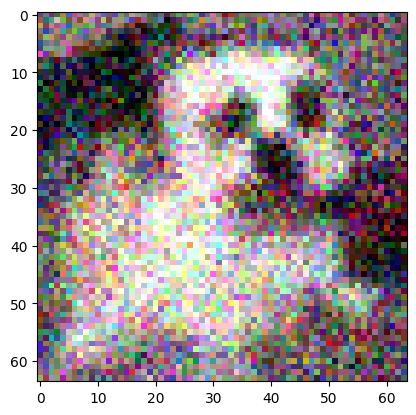

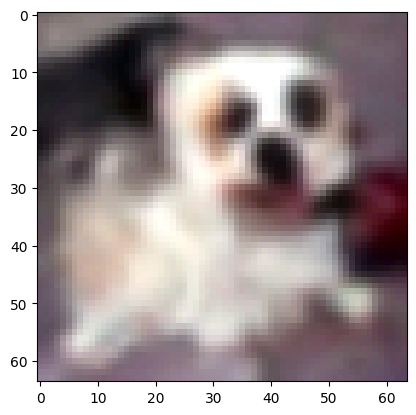

In [ ]:
from diffusion import Improved_CFG_Diffusion
from model import UNet
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch

cifar10_dict = dataset.class_to_idx
dtype = dataset.__getitem__(0)[0].dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fill in the name
name = "dog"

# create a random noise to generate image
noise = torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE)

# get the label
label = torch.tensor([cifar10_dict[name]], dtype = torch.long, device = DEVICE)

model = UNet(num_classes = num_classes, device = DEVICE)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ckpt.pt")))
model = model.to(device)

ema_model = optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(beta))
ema_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ema_ckpt.pt")))
ema_model = ema_model.to(DEVICE)

optim.swa_utils.update_bn(train_dataloader, ema_model)

# create a diffusion object
diffusion = Improved_CFG_Diffusion(1024, (image_size, image_size), dtype = dtype, device = DEVICE)

# generate image
image = diffusion.inference(ema_model, noise, label = label)

plt.imshow(image[0].cpu().permute(1, 2, 0))
plt.show()

NON EMA MODEL

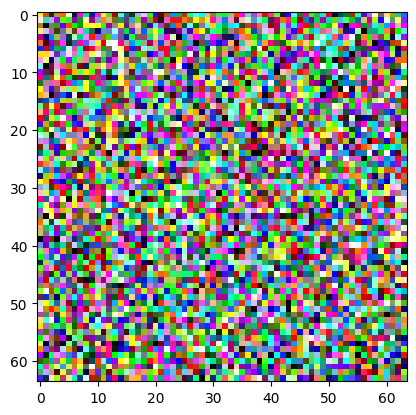

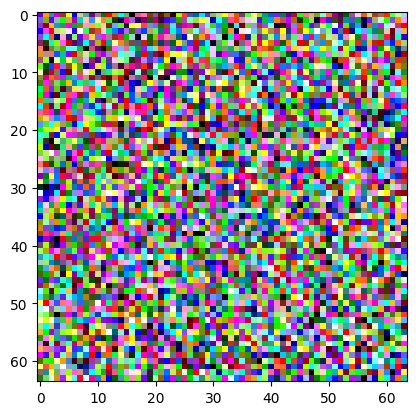

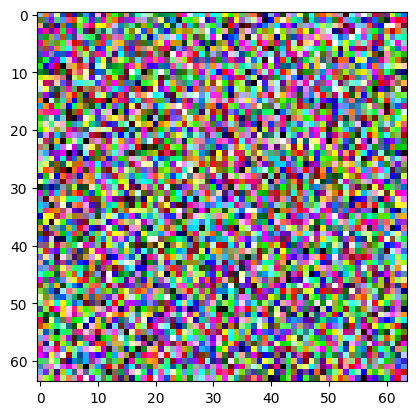

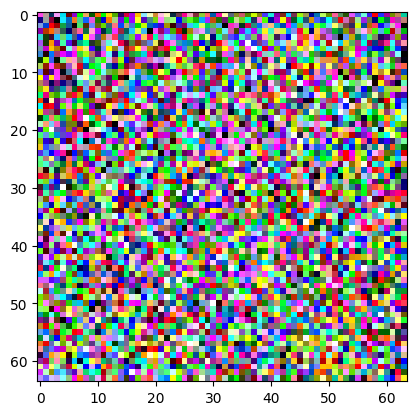

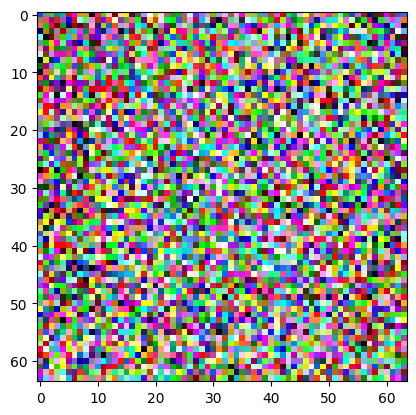

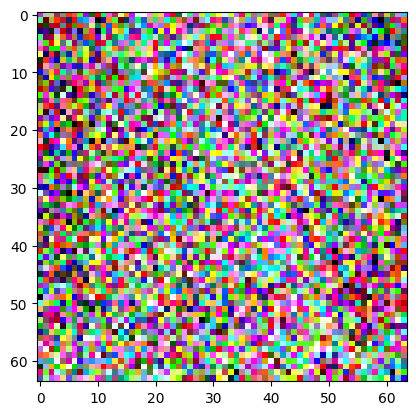

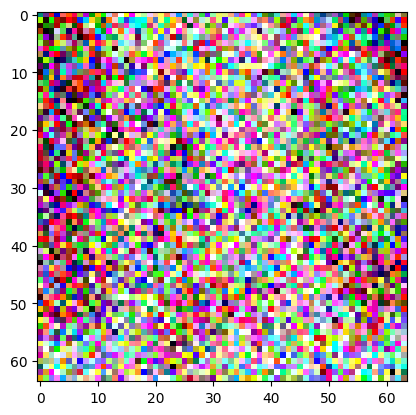

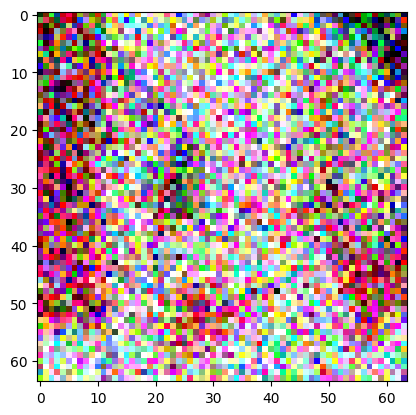

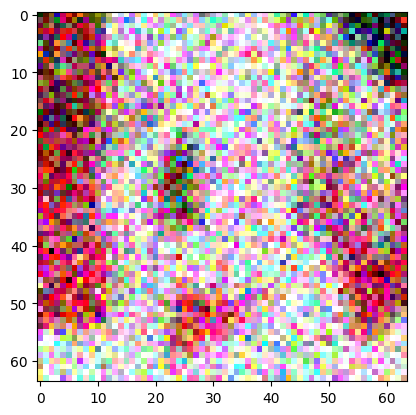

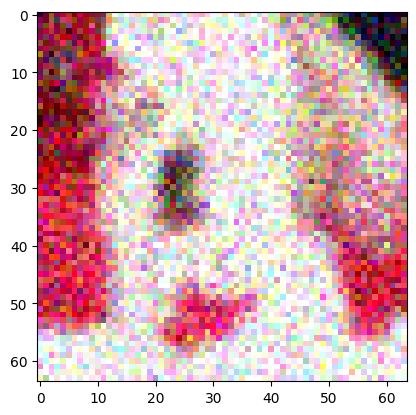

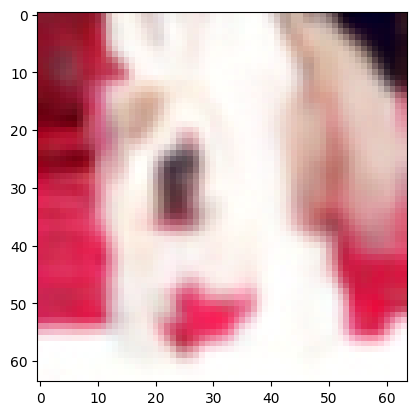

In [ ]:
from diffusion import Improved_CFG_Diffusion
from model import UNet
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch

cifar10_dict = dataset.class_to_idx
dtype = dataset.__getitem__(0)[0].dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fill in the name
name = "dog"

# create a random noise to generate image
noise = torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE)

# get the label
label = torch.tensor([cifar10_dict[name]], dtype = torch.long, device = DEVICE)

model = UNet(num_classes = num_classes, device = DEVICE)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ckpt.pt")))
model = model.to(device)

# create a diffusion object
diffusion = Improved_CFG_Diffusion(1024, (image_size, image_size), dtype = dtype, device = DEVICE)

# generate image
image = diffusion.inference(model, noise, label = label)

plt.imshow(image[0].cpu().permute(1, 2, 0))
plt.show()

# Gif generator

In [ ]:
from diffusion import Improved_CFG_Diffusion
from model import UNet
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch

cifar10_dict = dataset.class_to_idx
dtype = dataset.__getitem__(0)[0].dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fill in the name
name = "dog"

# create a random noise to generate image
noise = torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE)

# get the label
label = torch.tensor([cifar10_dict[name]], dtype = torch.long, device = DEVICE)

model = UNet(num_classes = num_classes, device = DEVICE)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ckpt.pt")))
model = model.to(device)

ema_model = optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(beta))
ema_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ema_ckpt.pt")))
ema_model = ema_model.to(DEVICE)

optim.swa_utils.update_bn(train_dataloader, ema_model)

# create a diffusion object
diffusion = Improved_CFG_Diffusion(1024, (image_size, image_size), dtype = dtype, device = DEVICE)

# generate image
image_array = diffusion.inference_gif(ema_model, noise, label = label)

from moviepy.editor import ImageSequenceClip
import cv2  # Assuming OpenCV for tensor to image conversion
from IPython.display import display

images = []
for tensor in image_array:
  # Convert tensor to RGB image (assuming uint8 format)
  image = (tensor.cpu().numpy() * 255).astype(np.uint8)
  images.append(image)

clip = ImageSequenceClip(images, fps=5)  # Adjust fps as needed
clip.write_gif(os.path.join(GOOGLE_DRIVE_PATH, "videos", f"{name}.gif"))  # Adjust fps as needed

MoviePy - Building file drive/MyDrive/stat-453/videos/dog.gif with imageio.


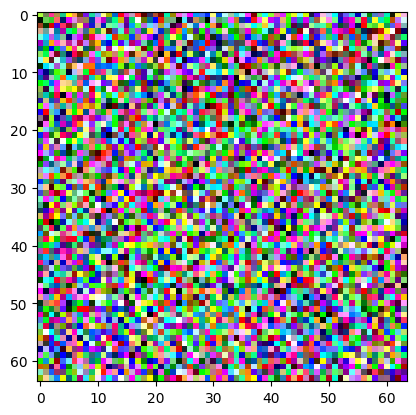

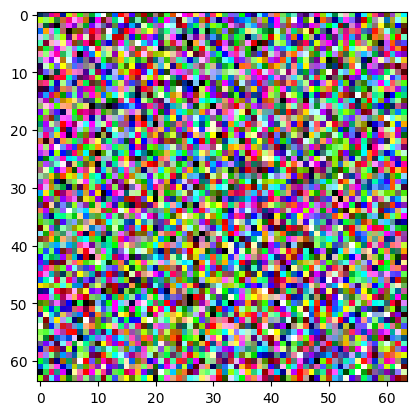

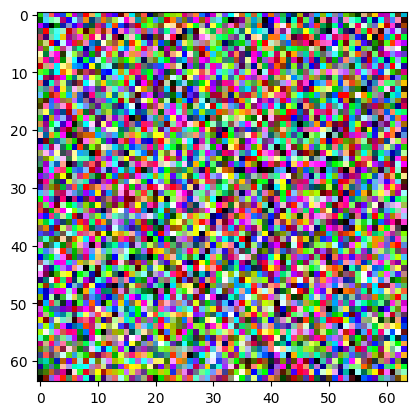

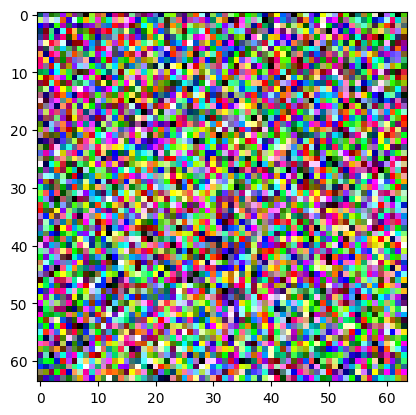

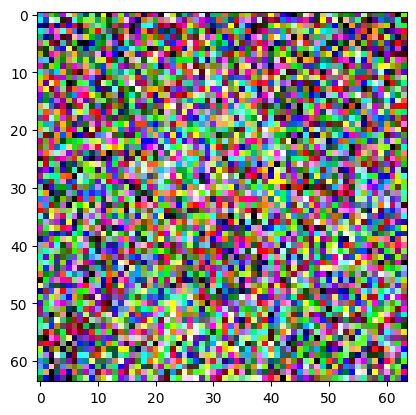

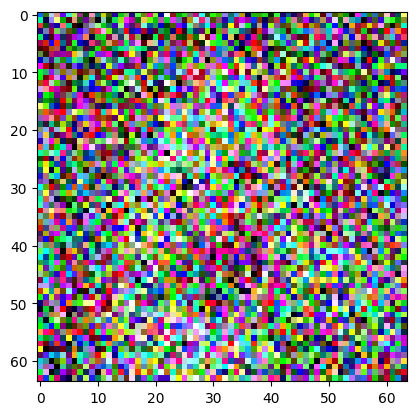

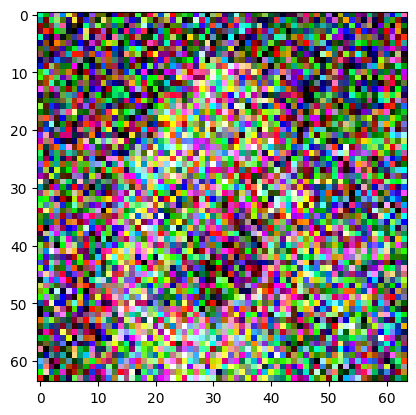

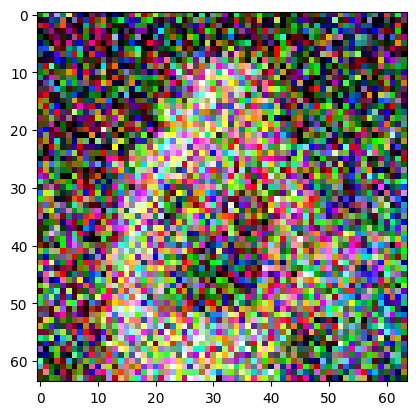

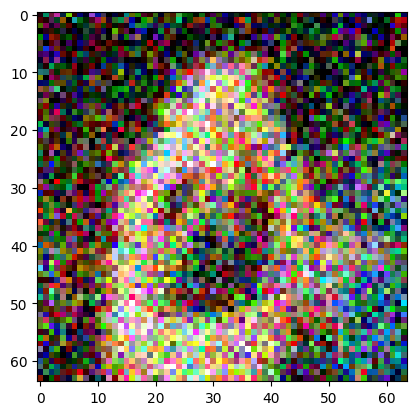

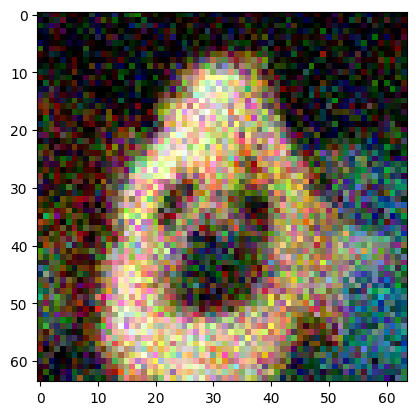

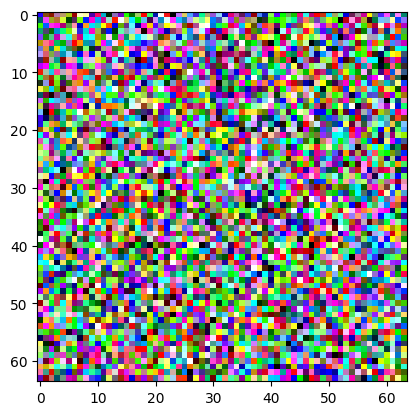

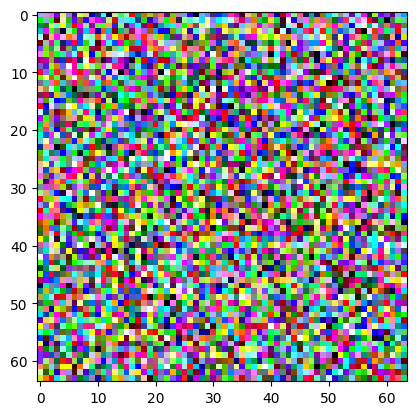

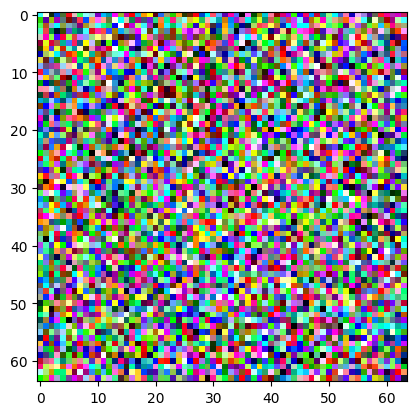

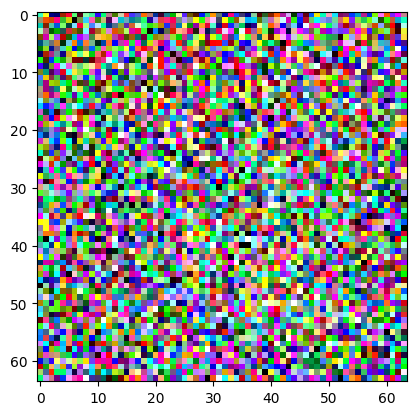

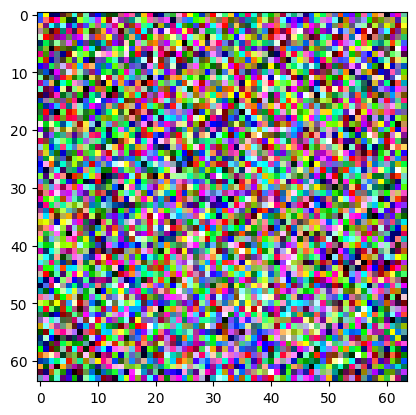

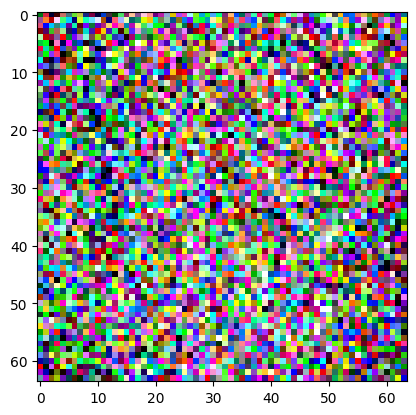

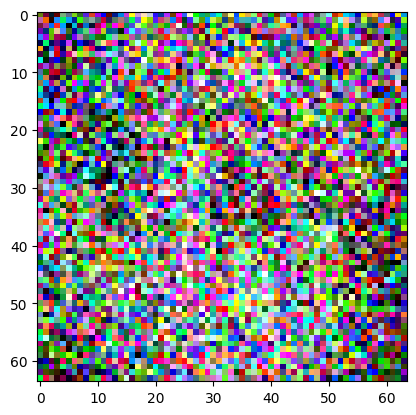

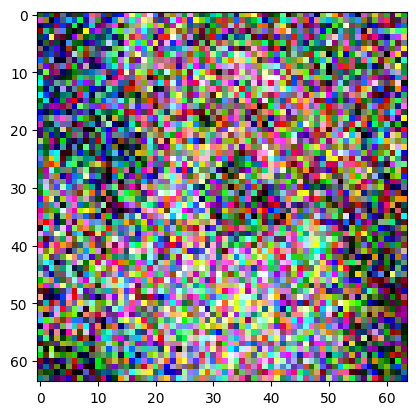

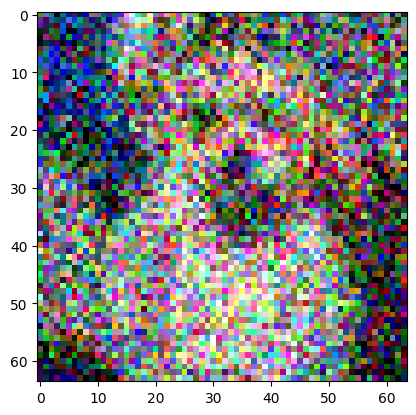

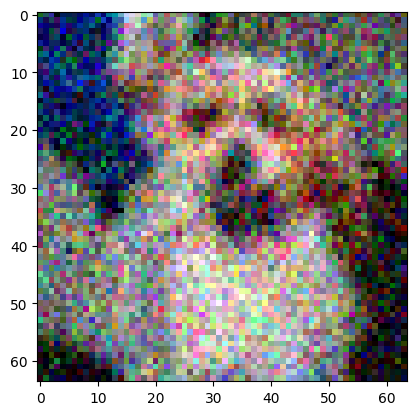

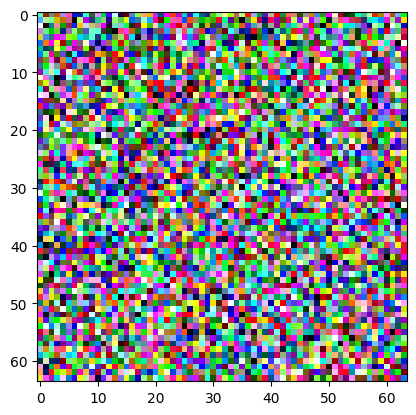

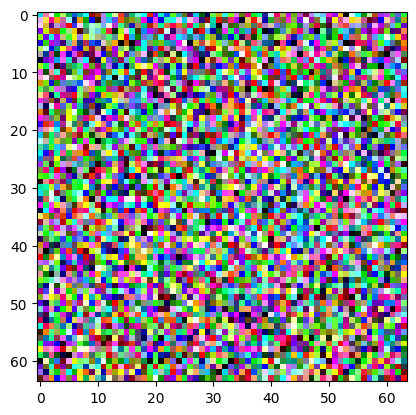

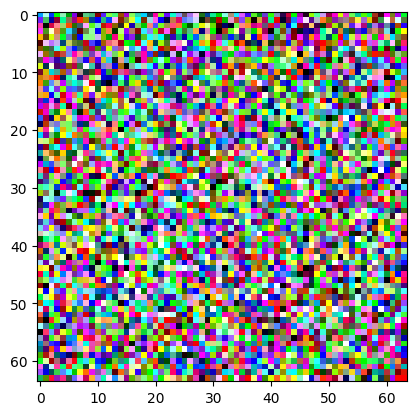

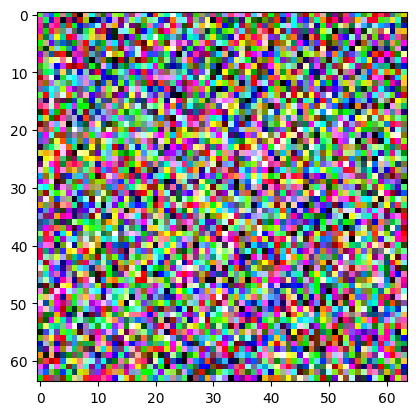

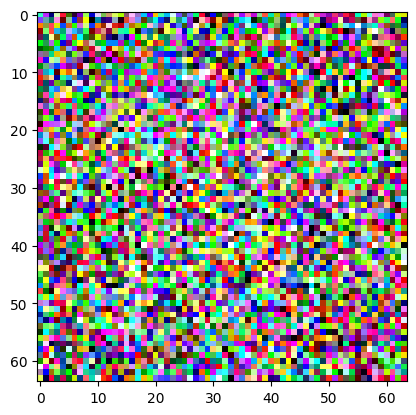

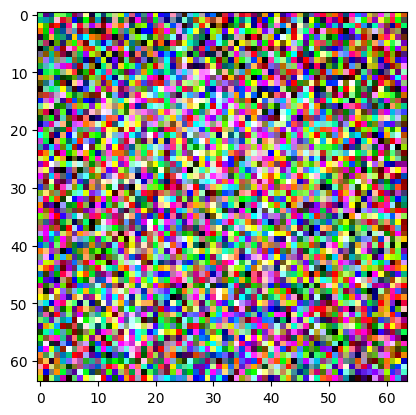

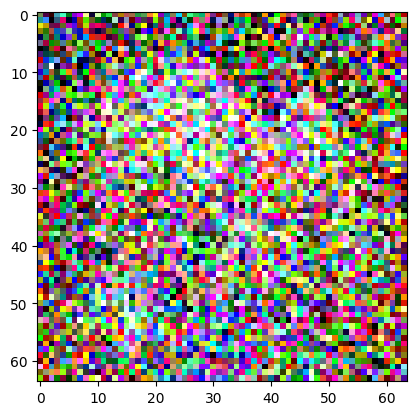

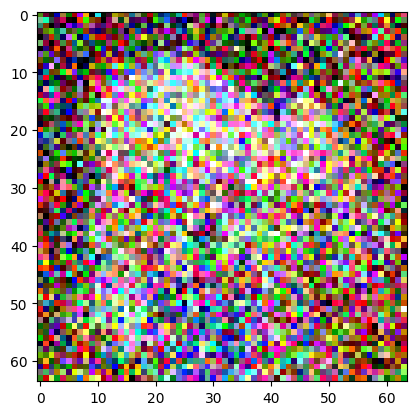

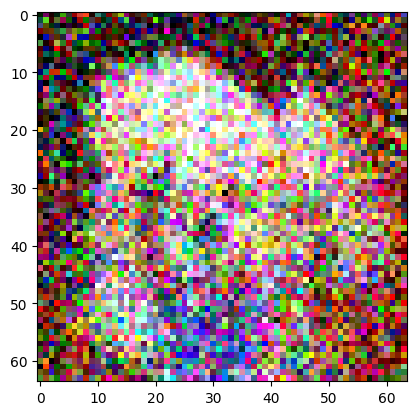

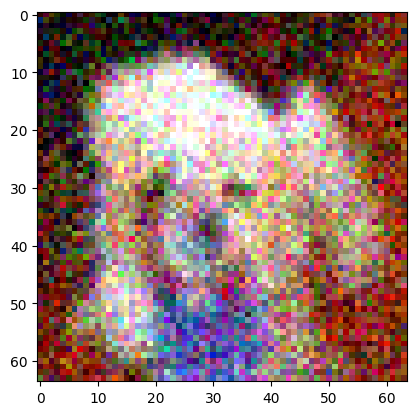

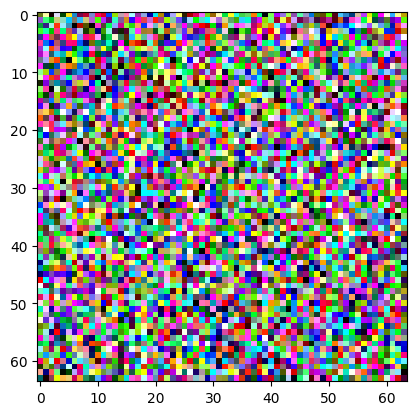

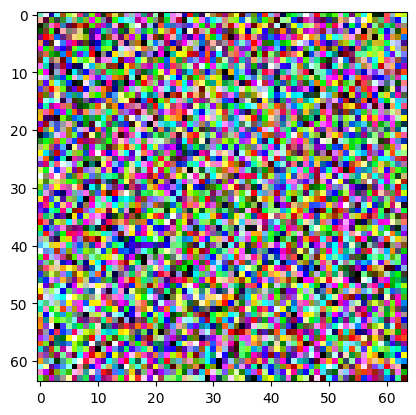

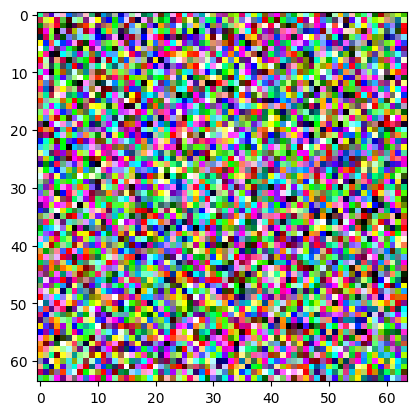

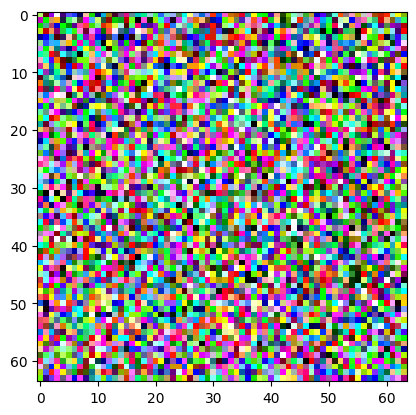

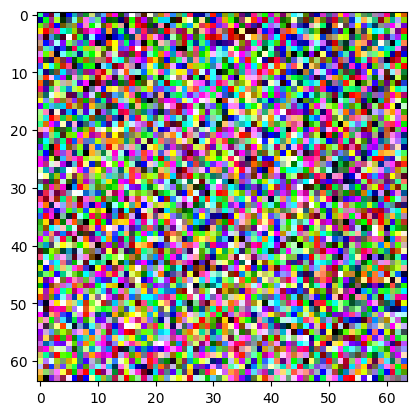

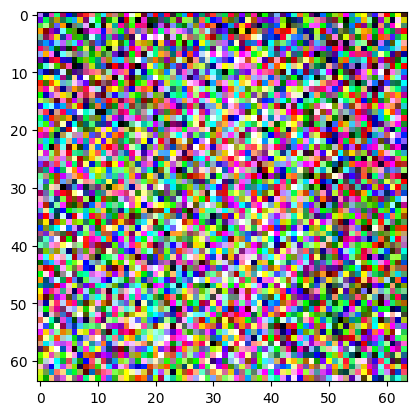

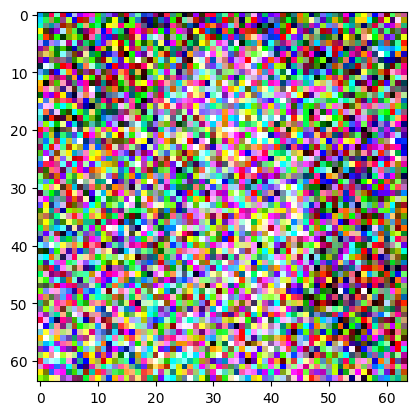

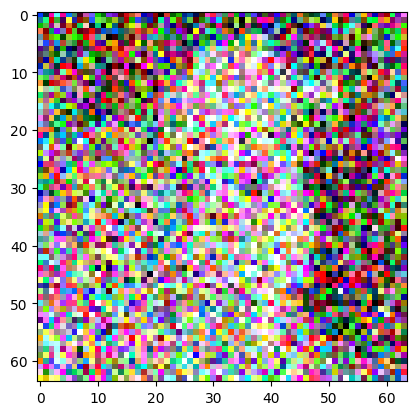

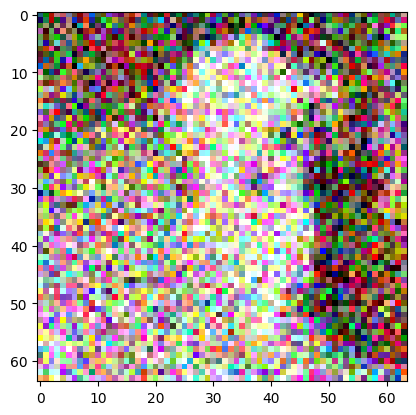

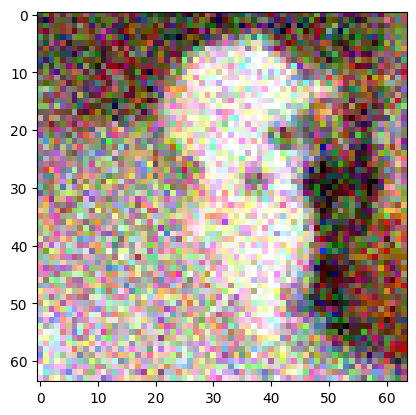

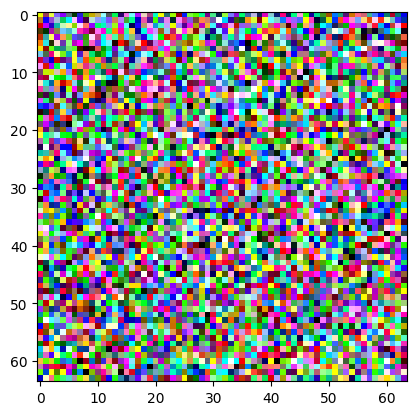

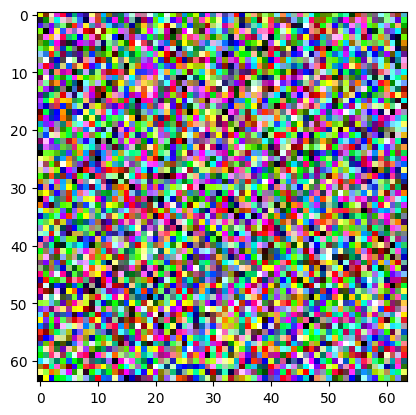

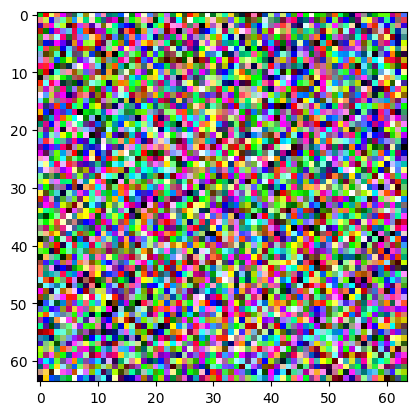

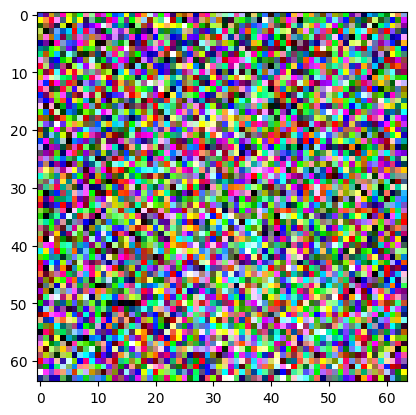

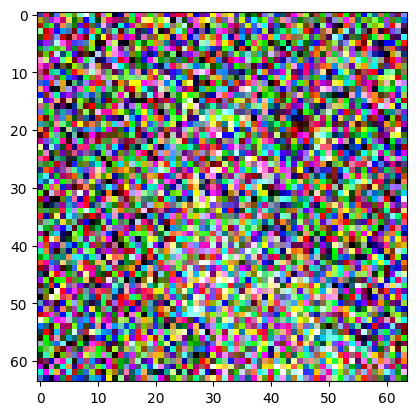

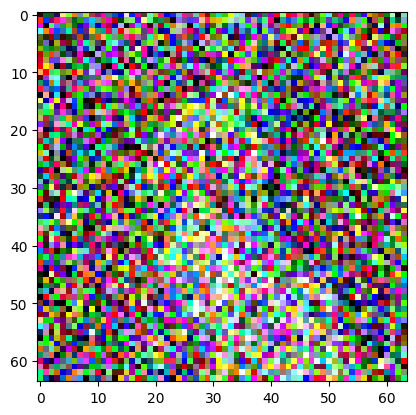

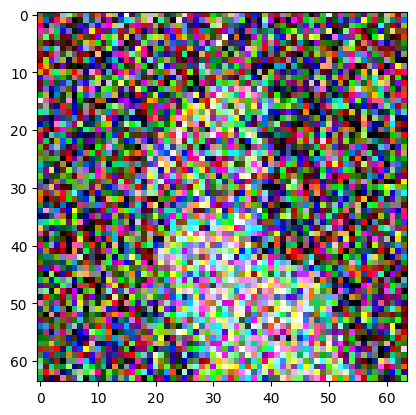

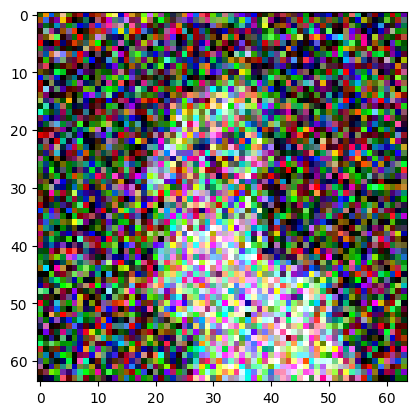

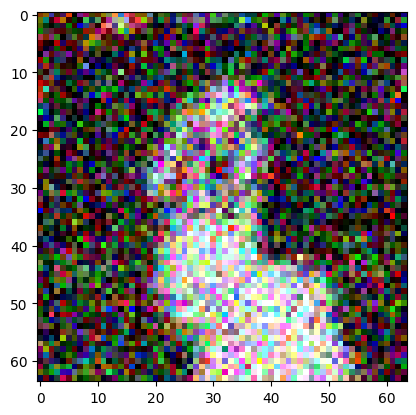

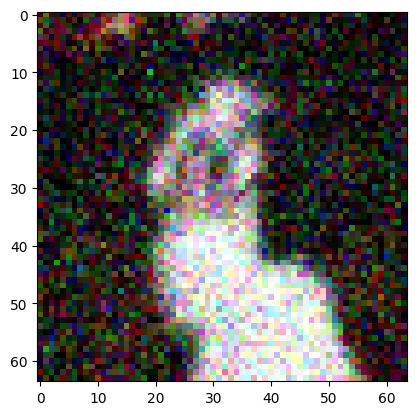

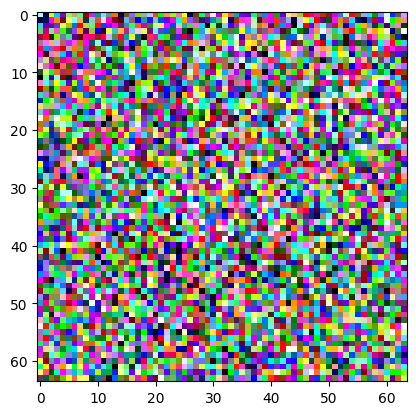

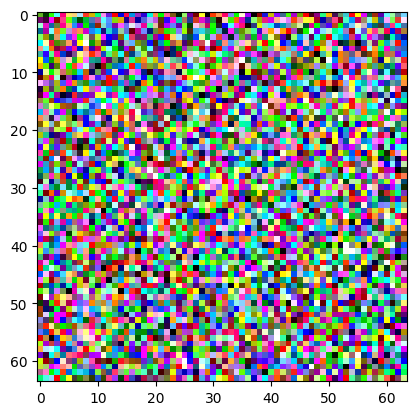

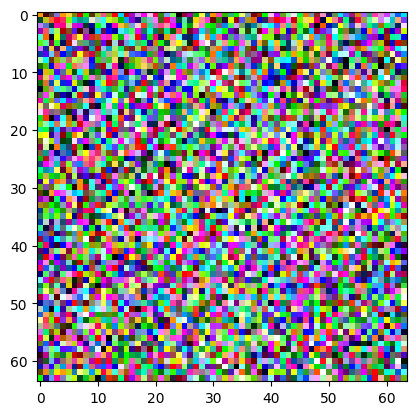

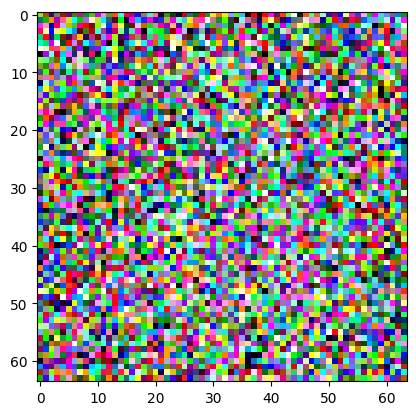

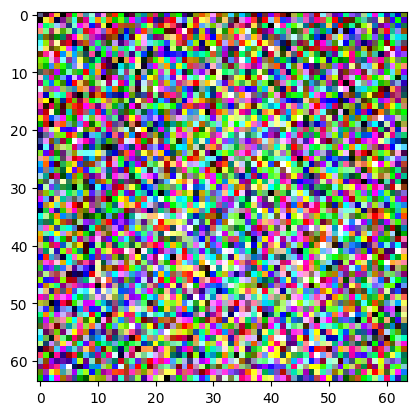

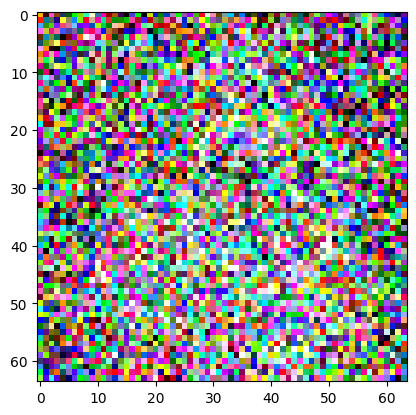

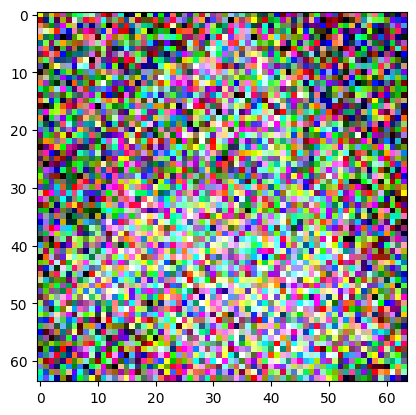

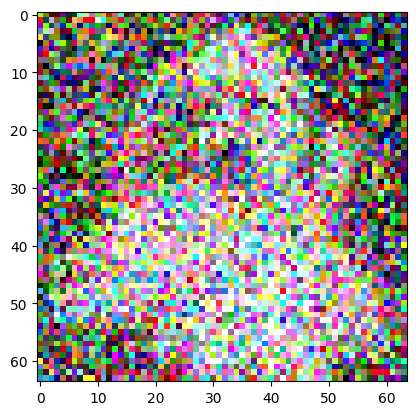

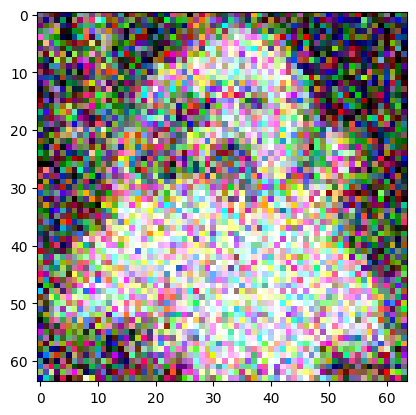

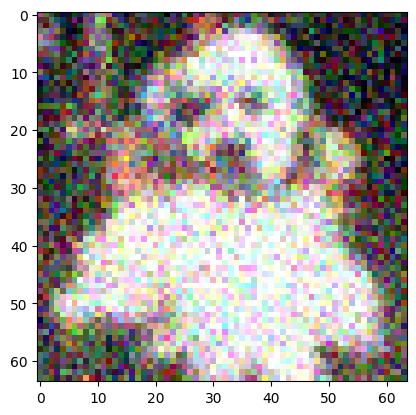

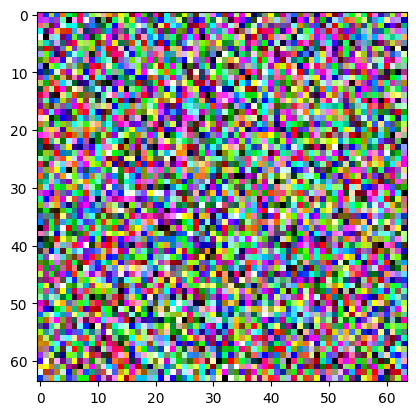

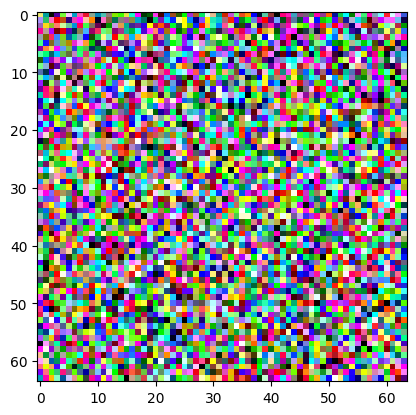

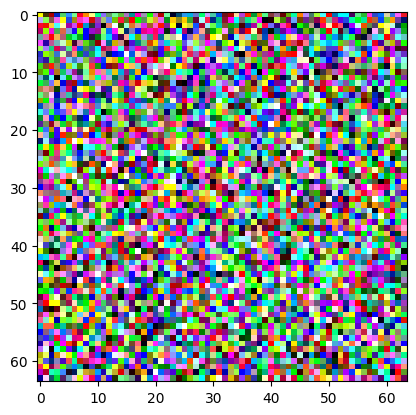

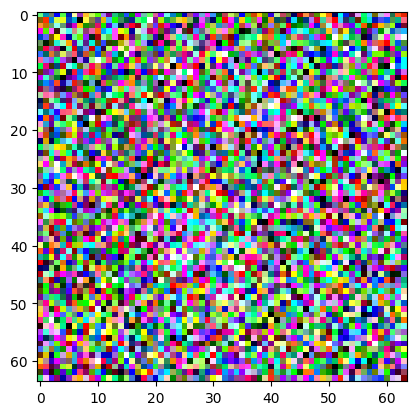

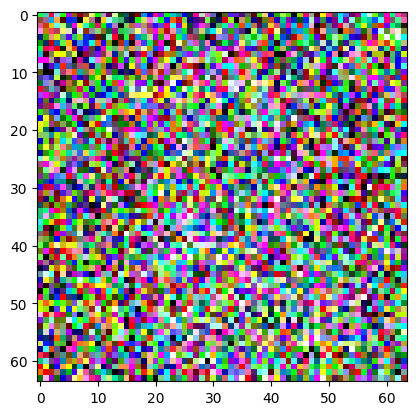

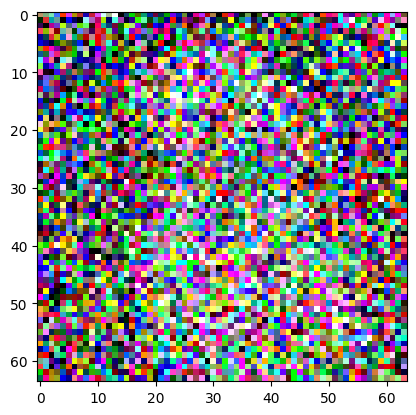

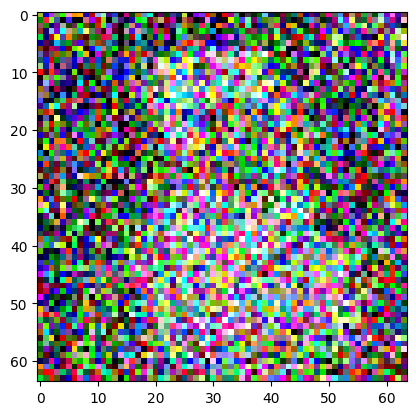

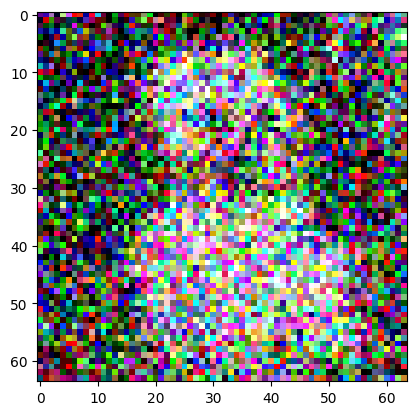

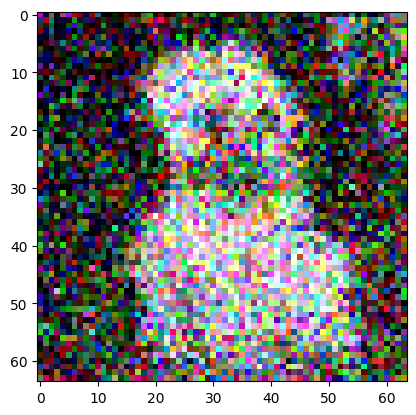

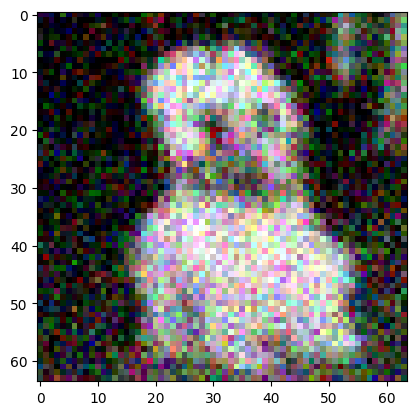

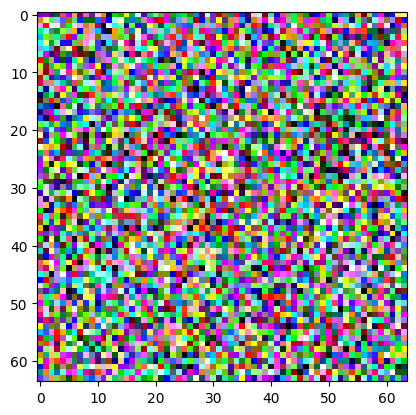

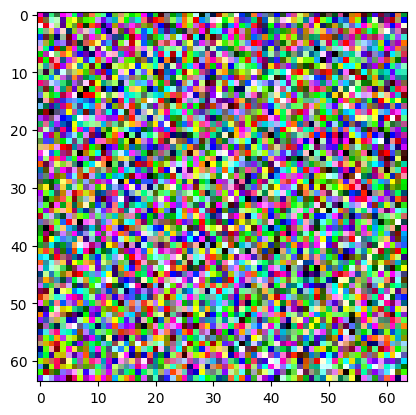

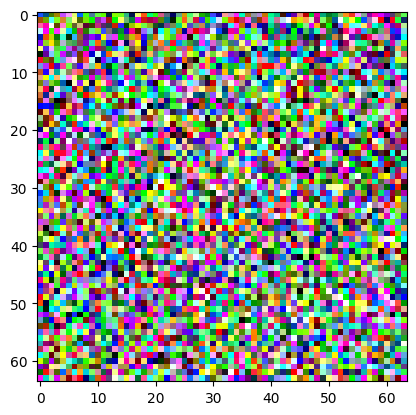

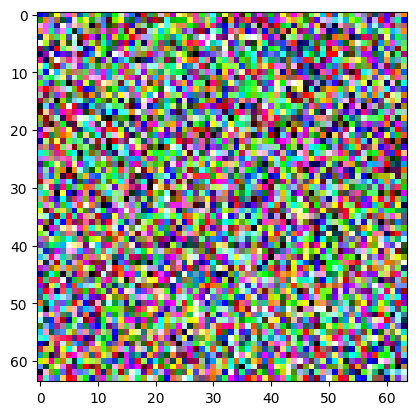

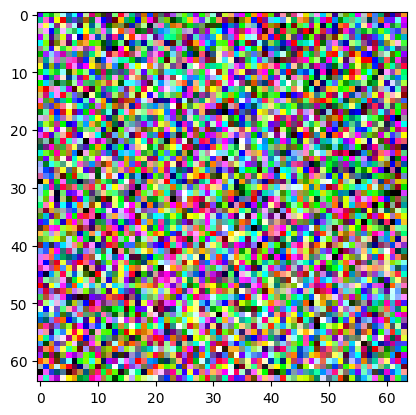

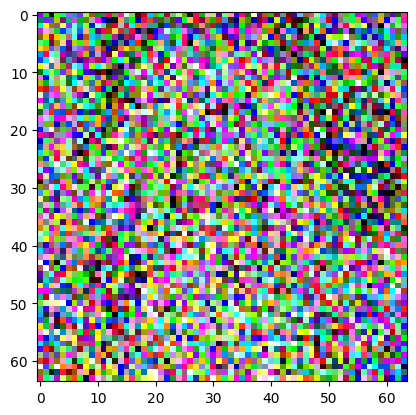

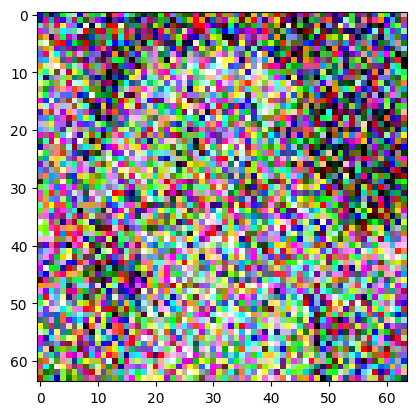

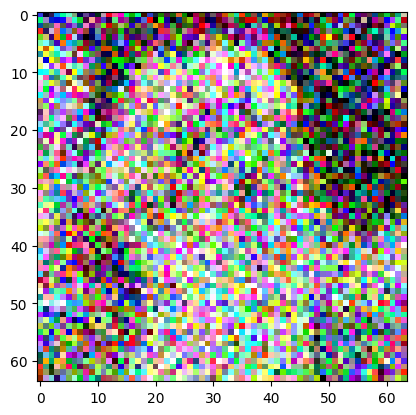

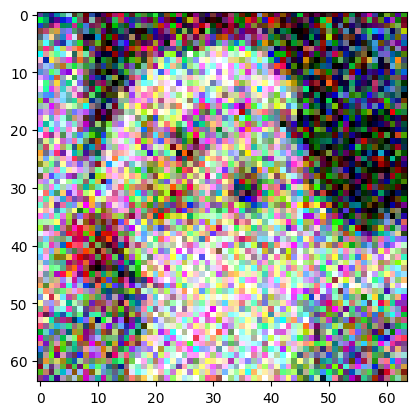

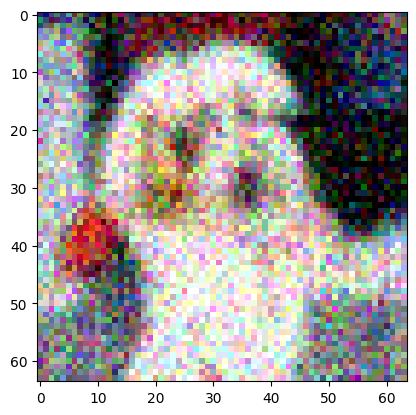

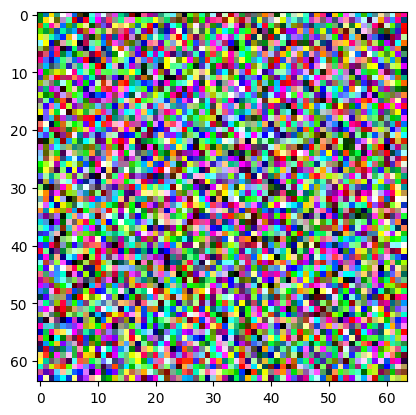

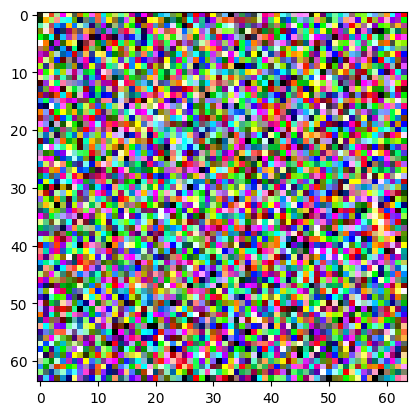

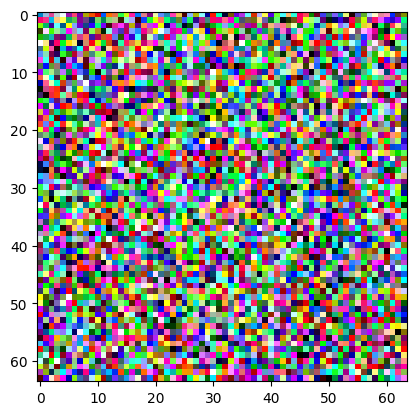

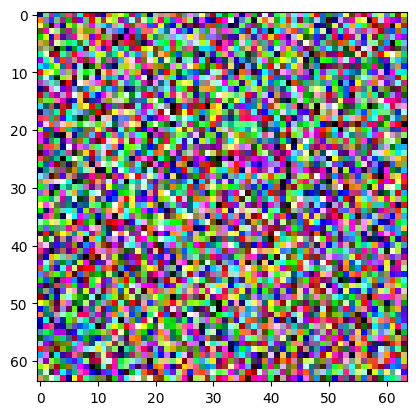

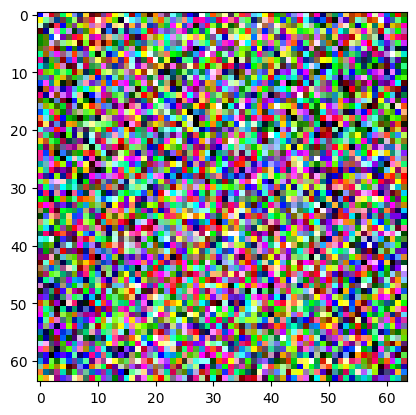

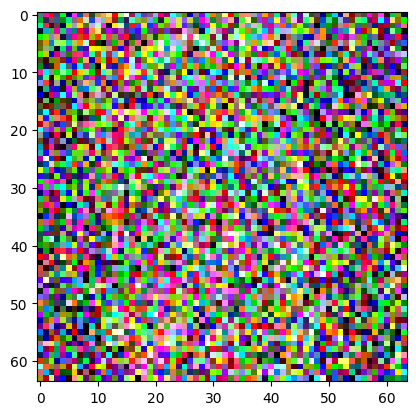

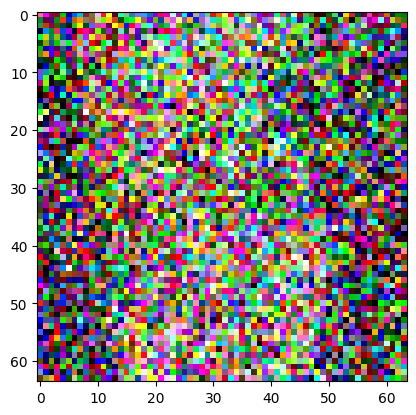

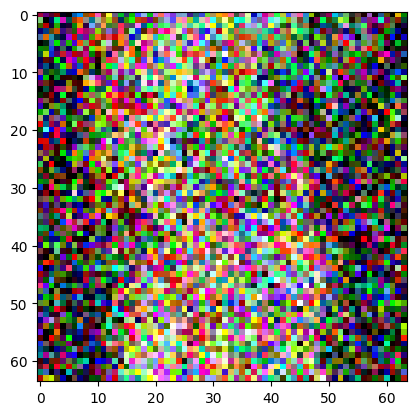

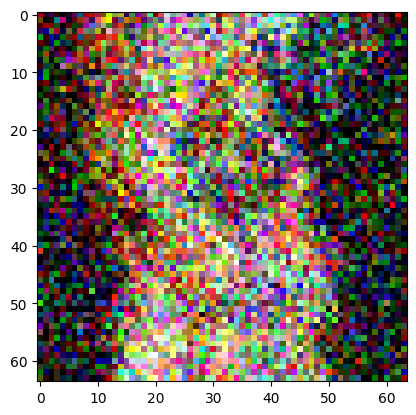

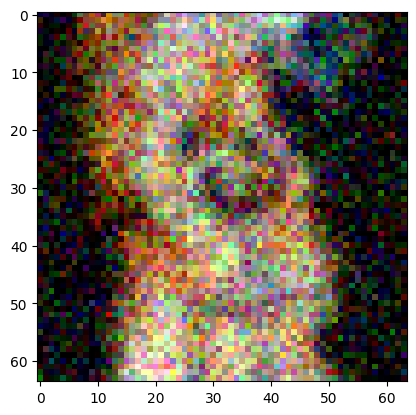

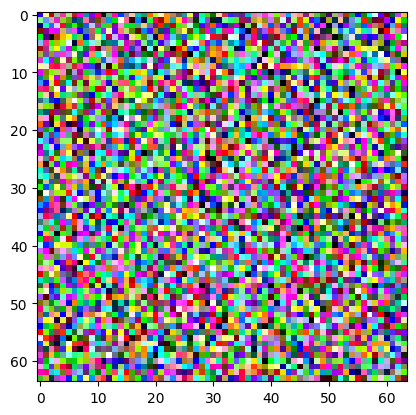

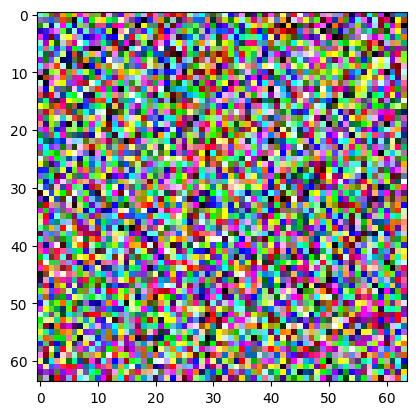

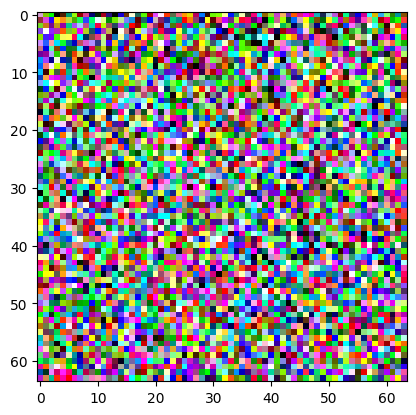

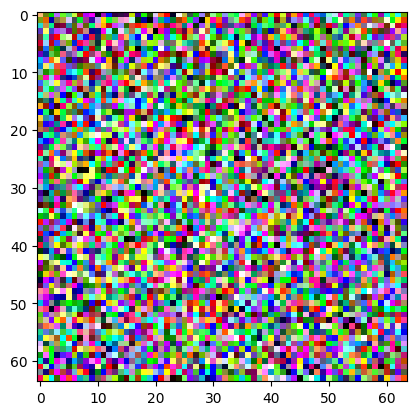

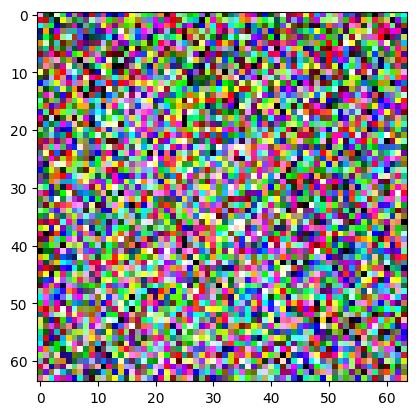

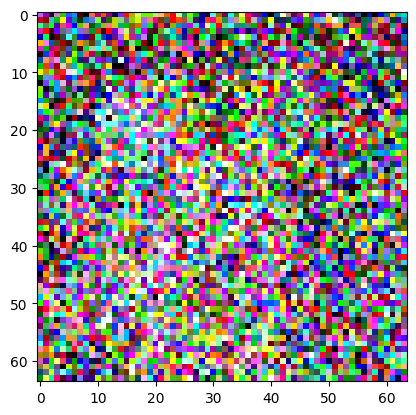

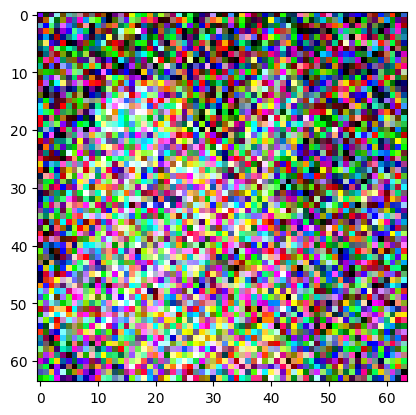

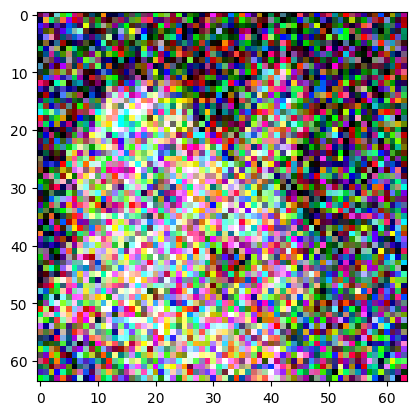

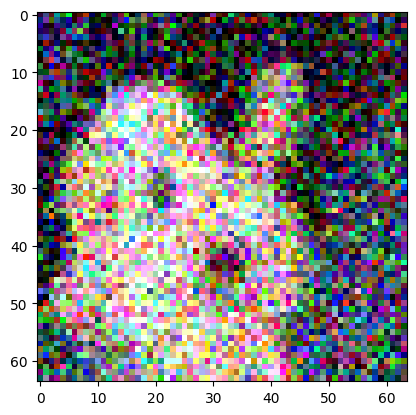

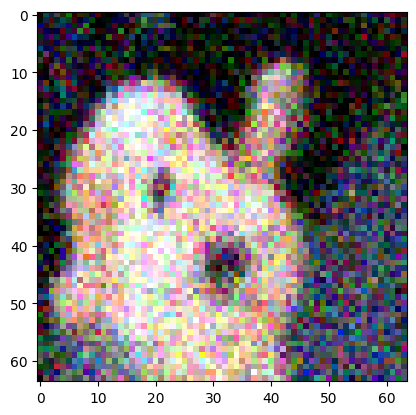

In [ ]:
from diffusion import Improved_CFG_Diffusion
from model import UNet
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch

cifar10_dict = dataset.class_to_idx
dtype = dataset.__getitem__(0)[0].dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = []

# fill in the name
name = "dog"

beta = 0.995
dtype = dataset.__getitem__(0)[0].dtype
num_classes = len(dataset.classes)


# create a random noise to generate image
noises = [torch.randn((1, 3, image_size, image_size), dtype = dtype, device = DEVICE) for _ in range(10)]

# get the label
label = torch.tensor([cifar10_dict[name]], dtype = torch.long, device = DEVICE)

model = UNet(num_classes = num_classes, device = DEVICE)
model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ckpt.pt")))
model = model.to(device)

ema_model = optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(beta))
ema_model.load_state_dict(torch.load(os.path.join(GOOGLE_DRIVE_PATH, "models", f"cifar_ema_ckpt.pt")))
ema_model = ema_model.to(DEVICE)

optim.swa_utils.update_bn(train_dataloader, ema_model)

# create a diffusion object
diffusion = Improved_CFG_Diffusion(1024, (image_size, image_size), dtype = dtype, device = DEVICE)

# generate image
for noise in noises:
  images.append(diffusion.inference(ema_model, noise, label = label))

from IPython.display import clear_output
clear_output(wait=True)

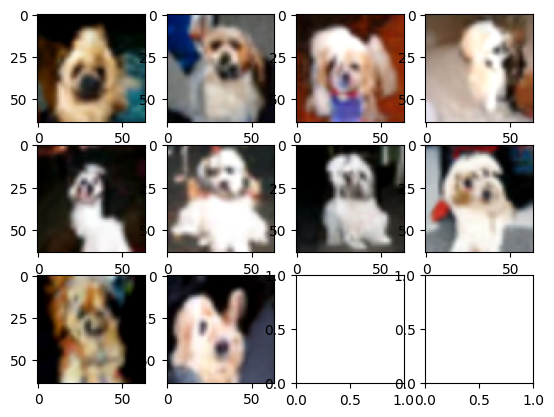

In [ ]:
fig, ax = plt.subplots(3, 4)

for idx in range(10):
  image = images[idx]
  ax[idx // 4][idx % 4].imshow(image[0].cpu().permute(1, 2, 0))
plt.show()